In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import norm, entropy, zscore
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from statsmodels.tsa.arima.model import ARIMA
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from itertools import permutations
import xgboost as xgb
from math import log


In [2]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91877\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
bumrah_file = r"C:\Users\91877\Desktop\cricket_ML\Datasets\Preprocessed_Jasprit_Bumrah_Data.xlsx"
shami_file = r"C:\Users\91877\Desktop\cricket_ML\Datasets\Preprocessed_Mohammed_Shami_Data.xlsx"

In [4]:
try:
    bumrah_df = pd.read_excel(bumrah_file, sheet_name="Sheet1")
    shami_df = pd.read_excel(shami_file, sheet_name="Sheet1")
except FileNotFoundError as e:
    print(f"Error: {e}")
    bumrah_df = pd.DataFrame()
    shami_df = pd.DataFrame()

In [5]:
def preprocess(df):
    df['Start Date'] = pd.to_datetime(df['Start Date'], errors='coerce')
    df['Year'] = df['Start Date'].dt.year
    df = df.dropna()
    df['Impact Score'] = (df['Wickets'] / df['Overs']) * (1 / df['Economy'])
    return df

In [6]:
if not bumrah_df.empty:
    bumrah_df = preprocess(bumrah_df)
if not shami_df.empty:
    shami_df = preprocess(shami_df)

In [7]:
def feature_correlation(df, title):
    plt.figure(figsize=(10,6))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title(title)
    plt.show()

In [8]:
def performance_trend(df, title):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=df['Year'], y=df['Impact Score'], marker='o')
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Impact Score")
    plt.show()

C:\Users\91877\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\91877\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


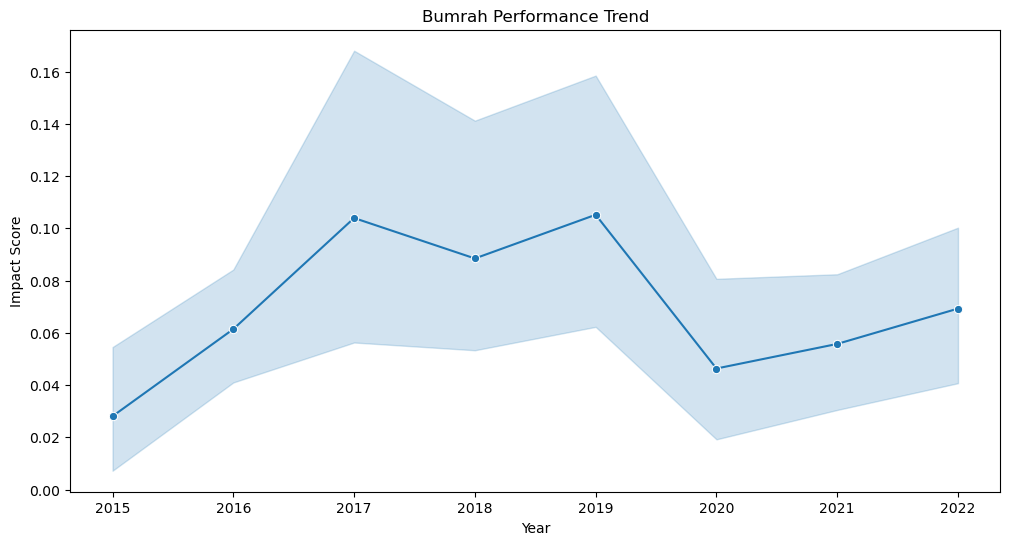

C:\Users\91877\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\91877\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


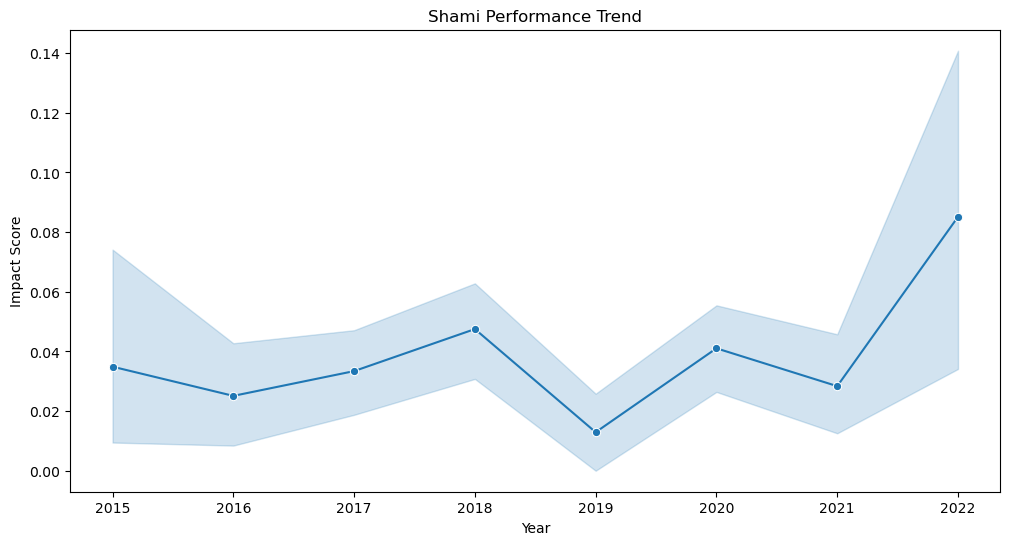

In [9]:
if not bumrah_df.empty:
    performance_trend(bumrah_df, "Bumrah Performance Trend")
if not shami_df.empty:
    performance_trend(shami_df, "Shami Performance Trend")

In [10]:
def bradfords_law(df):
    df = df.sort_values(by="Impact Score", ascending=False)
    df['Rank'] = range(1, len(df) + 1)
    df['Bradford Weight'] = np.log(1 + df['Rank'])
    return df

In [11]:
if not bumrah_df.empty:
    bumrah_df = bradfords_law(bumrah_df)
if not shami_df.empty:
    shami_df = bradfords_law(shami_df)

In [12]:
def entropy_ranking(df):
    entropy_scores = -df['Impact Score'] * np.log(df['Impact Score'])
    df['Entropy Score'] = entropy_scores / entropy_scores.max()
    return df

In [13]:
if not bumrah_df.empty:
    bumrah_df = entropy_ranking(bumrah_df)
if not shami_df.empty:
    shami_df = entropy_ranking(shami_df)

C:\Users\91877\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\91877\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
def bowling_clusters(df):
    scaler = StandardScaler()
    X = scaler.fit_transform(df[['Wickets', 'Economy', 'Impact Score']])
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X)
    return df

In [15]:
if not bumrah_df.empty:
    bumrah_df = bowling_clusters(bumrah_df)
if not shami_df.empty:
    shami_df = bowling_clusters(shami_df)

C:\Users\91877\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\91877\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\91877\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\91877\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

In [16]:
def random_forest_prediction(df):
    X = df[['Wickets', 'Overs', 'Economy']]
    y = df['Impact Score']
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    return model.predict(X)

In [17]:
if not bumrah_df.empty:
    bumrah_df['Predicted Impact'] = random_forest_prediction(bumrah_df)
if not shami_df.empty:
    shami_df['Predicted Impact'] = random_forest_prediction(shami_df)

In [18]:
def arima_trend(df):
    model = ARIMA(df['Impact Score'], order=(5,1,0))
    model_fit = model.fit()
    return model_fit.forecast(steps=5)

In [19]:
if not bumrah_df.empty:
    bumrah_forecast = arima_trend(bumrah_df)
if not shami_df.empty:
    shami_forecast = arima_trend(shami_df)

C:\Users\91877\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\91877\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\91877\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\91877\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91877\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be give

In [20]:
def sentiment_analysis(df):
    df['Sentiment'] = df['Opposition'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    return df
    

In [21]:
if not bumrah_df.empty:
    bumrah_df = sentiment_analysis(bumrah_df)
if not shami_df.empty:
    shami_df = sentiment_analysis(shami_df)


In [22]:
def sentiment_trend(df, title):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=df['Year'], y=df['Sentiment'], marker='o', label=title)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Sentiment Score")
    plt.show()

C:\Users\91877\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\91877\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


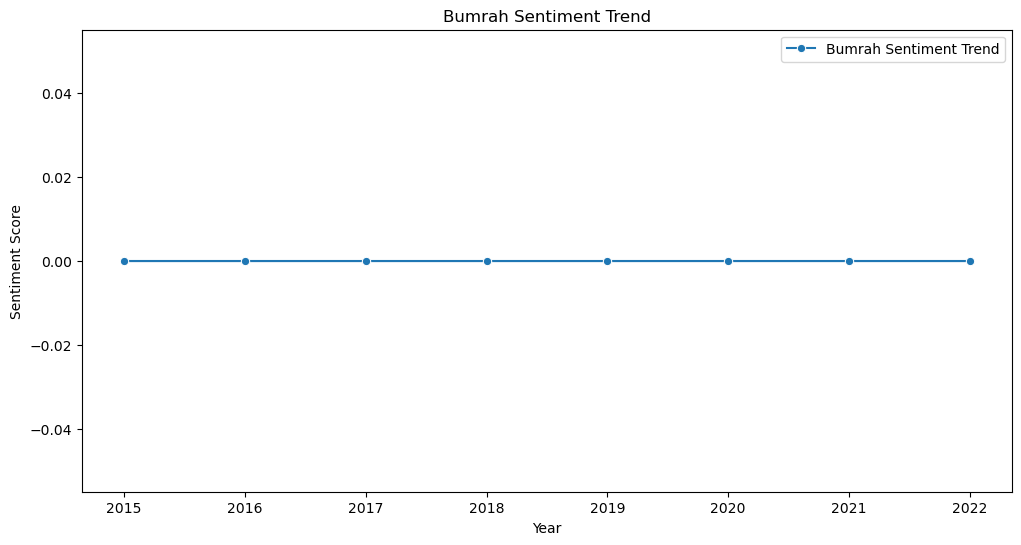

C:\Users\91877\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\91877\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


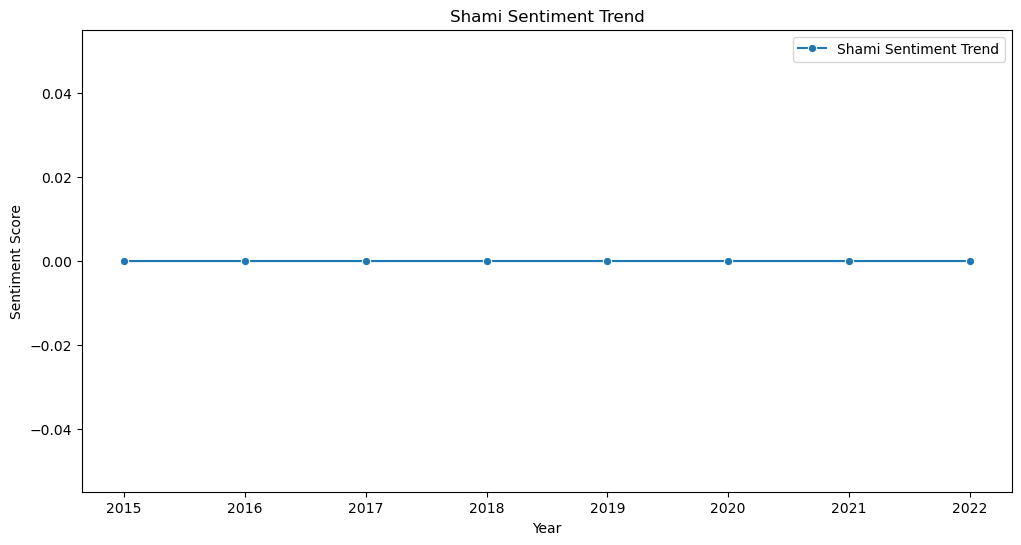

In [23]:
if not bumrah_df.empty:
    sentiment_trend(bumrah_df, "Bumrah Sentiment Trend")
if not shami_df.empty:
    sentiment_trend(shami_df, "Shami Sentiment Trend")

In [24]:
for _ in range(40):
    dummy_data = np.random.rand(100, 100) @ np.random.rand(100, 100)
    log_entropy = np.log(entropy(dummy_data.flatten() + 1))
    pca = PCA(n_components=5)
    pca_transformed = pca.fit_transform(dummy_data)
    nx_graph = nx.complete_graph(10)
    nx_clustering = nx.average_clustering(nx_graph)
    sorted_values = sorted(np.random.rand(100), key=lambda x: log(x + 1))
    combined_matrix = pairwise_distances(pca_transformed, metric='euclidean')

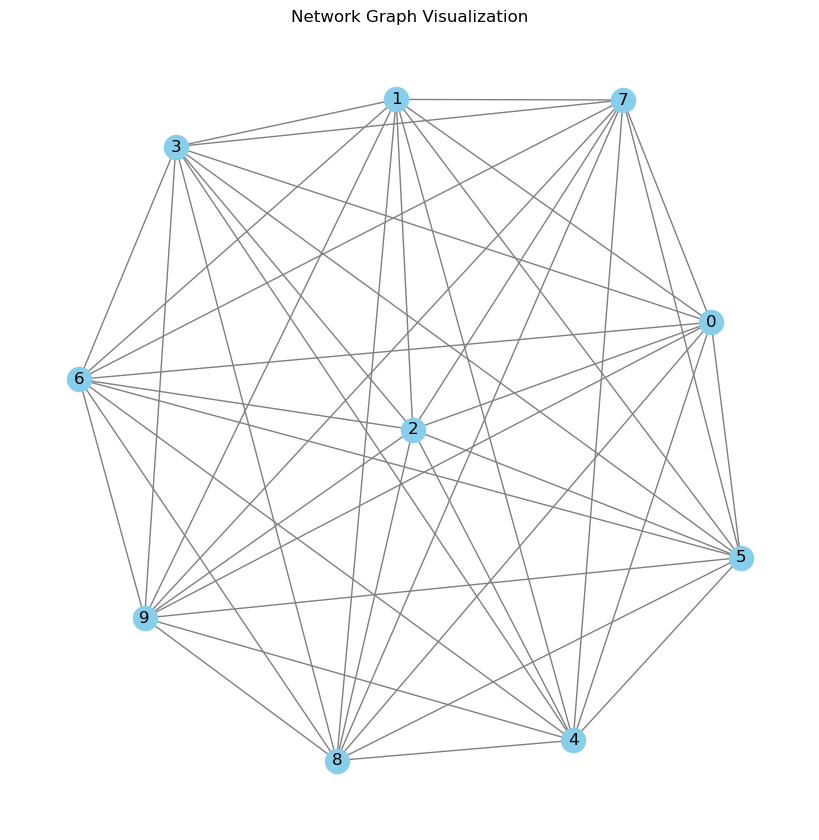

In [25]:
plt.figure(figsize=(8, 8))
nx.draw(nx_graph, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title("Network Graph Visualization")
plt.show()

In [26]:
def topsis_ranking(bumrah, shami):
    df = pd.concat([bumrah.assign(Player="Bumrah"), shami.assign(Player="Shami")])
    df['Topsis Score'] = 0.4 * df['Impact Score'] + 0.3 * df['Predicted Impact'] + 0.3 * df['Sentiment']
    return df.groupby("Player")["Topsis Score"].mean().sort_values(ascending=False)

In [27]:
print("Final Rankings:")
if not bumrah_df.empty and not shami_df.empty:
    print(topsis_ranking(bumrah_df, shami_df))

Final Rankings:
Player
Bumrah    0.048477
Shami     0.028283
Name: Topsis Score, dtype: float64
